# Proposal for Starbucks Capstone Project

## Domain Background

Starbucks, an American Coffee Company, which offers discount to mobile users who purchase items through the mobile app.

As a retail company that sells products to its consumers, increasing sales would be a major concern for them, and as a businesses look forward to increasing sales and revenue every year, establishing means to help with this using technology would be at the top of their list.

Using a simplified version of the real Starbucks app based on a simulator we seek to be able to determine demographic groups of consumers and also how they best respond to offers.

## Problem Statement

The goal of this project is to determine among demographic groups what **offer** they best respond to.

> An **offer** is an advertisement for a drink or an actual offer such as a Buy One Get One Free or a discount sent to users to spike interest in the product.

This problem has previously been tackled as a 

I chose this problem to tackle because I believe a major concern for a business is to increase revenue while at minimal cost.

For a business such as starbucks, offering discounts to people who do not need it, can count as a wasted opportunity.

A potential solution would be using data gotten on demographics and transactions conducted by consumers of starbucks products and building a model to determine what offer to offer to specific consumers.

Framing this problem as classification problem (multi-classification), I believe this is a suitable approach for this problem.

Identifying what **offer** a consumer best responds to among all possible offers.

## Datasets and Input

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app.


### 1. profile.json
This contains the demographic data for each customer.
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

In [2]:
profile = pd.read_json('profile.json', orient='records', lines=True)
profile.head(1)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN


### 2. portfolio.json
This contains offer ids and meta data about each offer (duration, type, etc.)


In [1]:
import pandas as pd
portfolio = pd.read_json('portfolio.json', orient='records', lines=True)
portfolio.head(1)

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10


### 3. transcript.json
This contains records for transactions, offers received, offers viewed, and offers completed

In [3]:
transcript = pd.read_json('transcript.json', orient='records', lines=True)
transcript.head(1)

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}


In [4]:
# Merge the transcript dataframe with the portfolio dataframe (metadata of offers)
transcript['offer_id'] = transcript['value'].apply(lambda value: value.get('offer id'))
transcript['amount'] = transcript['value'].apply(lambda value: value.get('amount'))
transcript.drop('value', axis=1, inplace=True)
transcript.head(1)

,event,person,time,offer_id,amount
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN


In [5]:
merged = transcript.merge(portfolio.rename(dict(id='offer_id'), axis=1), on='offer_id', how='left')
print(merged.shape[0], transcript.shape[0])
merged.head(1)

306534 306534


,event,person,time,offer_id,amount,channels,difficulty,duration,offer_type,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,"[web, email, mobile]",5.0,7.0,bogo,5.0


The merged dataset (transcript and portfolio) contains 

* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* offer_id (string) - offer id
* amount (string) - amount paid for product N.B when this did not include a promotional offer.
* difficulty (int) - minimum required spend to complete an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)
* offer_type (string) - type of offer ie BOGO, discount, informational, None. N.B None occurs when there is no offer indicated.
* reward (int) - reward given for completing an offer




Based on the information provided below we can see the dataset is imbalanced as 56% of our distribution already comes out as "None".

Using a F1 metric helps to avoid been misled by the more dominant class. 

In [6]:
merged['offer_type'].fillna('None', inplace=True)
merged['amount'].fillna('None', inplace=True)
merged['offer_type'].value_counts(normalize=True)

None             0.562848
bogo             0.182518
discount         0.169599
informational    0.085035
Name: offer_type, dtype: float64

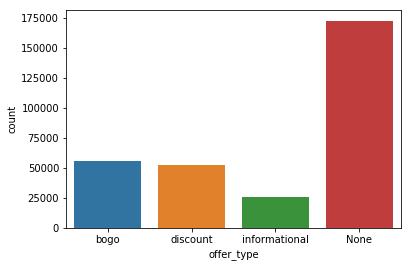

In [10]:
import seaborn as sns
sns.countplot(x='offer_type', data=merged)

## Solution Statement

A solution I propose would be to apply a Classification Machine Learning model after thorough analysis on demography data and transactions to determine if a user would respond to a particular offer or not.

With the information that there are 4 offers:

* Bogo
* Informational
* Discount
* None

This makes our model a multi-label classification model which would be useful in determine which of the offers (classes) listed above that a potential consumer would respond best to.

With the knowledge that some consumers do not purchase an item with an offer in mind, they do not need to recieve any offer, is the reason why **None** is also listed as a class.


## Benchmark Model

A benchmark model I would use would be the Naive Bayes Classifier.

The naiva bayes classification algorithm is a simplified assumption which tries to establish simple heuristics based on the data, which also requires small amount of training data to estimate the neccessary parameters.
In spite of their apparently over-simplified assumptions, naive Bayes classifiers have worked quite well in many real-world situations, famously document classification and spam filtering. [4]

Since this solution entails solving as a multiclass classification problem, and this model is pretty simple, this would be a good benchmark model to evaluate against.

## Evaluation Metrics

An evaluation metric that would be used on this problem would be the F1-score, specifically the Macro F1 metric [2]





## Project Design

#### Data Preparation
I would proceed to merge datasets together, `transcript.json` with both the `porfolio.json` and `profile.json`, as this all hold data that describe entities describe in the transcript.

#### Data Analysis / Visualizations 
This step would involve data analysis to determine what features are useful for determining what offer a consumer best responds.
The data would be analyzed and visualizations constructed to carefully understand what data is inconsistent and where work could be done to handle imbalance.

Handling missing values, using methods such as Imputation or simply dropping them, depending on the percieved effect this could have on the final solution.

Looking at the classes we are trying to predict, we can already see that there is some level of imbalance, a possible approach to solving this could be [3] 
1. Using more evaluation metrics other than F1 such as AUC/ROC
2. Resampling this dataset.
3. SMOTING - Generating synthetic samples
4. Trying different algorithms to determine what performs best.

Using the methods suggested above, class imbalance can be handled.

#### Model Selection
N.B while it is not very important to construct a model once thorough data analysis has been done, I suggest doing this to enable prediction of what a class a consumer would be in.

Using a Classification Model that would be trained on the data we will build a multi-category classifier that would be able to identify which offers consumers would respond to best.

Since there are 4 classes we are checking for which seems to be well distributed except for the 

```
None             56,2848
bogo             18.2518
discount         16.9599
informational    8.5035
```

A (Random Forest)[4] would be used in this problem as this is a very useful ensemble algorithm.
This classification model would be used to predict which offer a demographic would best respond to.


#### Testing & Evaluation
Using a testing set (and validation set) which was kept aside during the model selection and building process to test the model, and using the evaluation metric I indicated above - F1 Score, I would proceed to check how best this model performed, while also comparing to the baseline model I have indicated, as this must outperform the baseline model.

#### Hyperparameter Tuning
In an effort to produce the best results, hyperparameters are to be tuned to ensure the model performs as best as it should on the provided dataset, and on a testing set.


## References

1. Wikipedia (F1 Score)

https://en.wikipedia.org/wiki/F1_score

2. Macro F1

https://arxiv.org/abs/1911.03347

3. Handling Imbalanced Datasets.

https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/

3. Random Forest

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier

4. Naive Bayes
https://scikit-learn.org/stable/modules/naive_bayes.html